# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.GELU(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.GELU(),
            nn.Linear(hidden5_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 5, 5, 5, 5, 5, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=5, out_features=5, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=5, out_features=5, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=5, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 5, 5, 5, 5, 5, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 0.9107
Epoch 1/200, Iteration 2/12, Loss: 1.1568
Epoch 1/200, Iteration 3/12, Loss: 1.0718
Epoch 1/200, Iteration 4/12, Loss: 1.1251
Epoch 1/200, Iteration 5/12, Loss: 0.9257
Epoch 1/200, Iteration 6/12, Loss: 1.1948
Epoch 1/200, Iteration 7/12, Loss: 0.8493
Epoch 1/200, Iteration 8/12, Loss: 0.8400
Epoch 1/200, Iteration 9/12, Loss: 1.1282
Epoch 1/200, Iteration 10/12, Loss: 1.0893
Epoch 1/200, Iteration 11/12, Loss: 0.9951
Epoch 1/200, Iteration 12/12, Loss: 0.9653
Epoch 1/200, Iteration 13/12, Loss: 1.1660
Train Error: 
 Accuracy: 45.75%, Avg loss: 1.002883, MRE: 0.712366, MAE: 0.112612 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.890187, MRE: 0.574115, MAE: 0.100018 

Epoch 2/200, Iteration 1/12, Loss: 1.0708
Epoch 2/200, Iteration 2/12, Loss: 0.7010
Epoch 2/200, Iteration 3/12, Loss: 1.0592
Epoch 2/200, Iteration 4/12, Loss: 0.9726
Epoch 2/200, Iteration 5/12, Loss: 0.9502
Epoch 2/200, Iteration 6/12, Loss: 0.9320
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 56.0%, Avg loss: 0.156339, MRE: 0.243709, MAE: 0.039477 

Test Error: 
 Accuracy: 53.0%, Avg loss: 0.132075, MRE: 0.195247, MAE: 0.036507 

Epoch 13/200, Iteration 1/12, Loss: 0.1236
Epoch 13/200, Iteration 2/12, Loss: 0.1518
Epoch 13/200, Iteration 3/12, Loss: 0.1600
Epoch 13/200, Iteration 4/12, Loss: 0.1243
Epoch 13/200, Iteration 5/12, Loss: 0.1482
Epoch 13/200, Iteration 6/12, Loss: 0.0855
Epoch 13/200, Iteration 7/12, Loss: 0.1445
Epoch 13/200, Iteration 8/12, Loss: 0.1251
Epoch 13/200, Iteration 9/12, Loss: 0.1815
Epoch 13/200, Iteration 10/12, Loss: 0.1039
Epoch 13/200, Iteration 11/12, Loss: 0.0940
Epoch 13/200, Iteration 12/12, Loss: 0.0944
Epoch 13/200, Iteration 13/12, Loss: 0.1125
Train Error: 
 Accuracy: 60.12%, Avg loss: 0.092002, MRE: 0.188977, MAE: 0.031708 

Test Error: 
 Accuracy: 61.0%, Avg loss: 0.088267, MRE: 0.165710, MAE: 0.031282 

Epoch 14/200, Iteration 1/12, Loss: 0.0812
Epoch 14/200, Iteration 2/12, Loss: 0.0875
Epoch 14/200, Iterat

Epoch 24/200, Iteration 8/12, Loss: 0.0088
Epoch 24/200, Iteration 9/12, Loss: 0.0155
Epoch 24/200, Iteration 10/12, Loss: 0.0235
Epoch 24/200, Iteration 11/12, Loss: 0.0125
Epoch 24/200, Iteration 12/12, Loss: 0.0113
Epoch 24/200, Iteration 13/12, Loss: 0.0180
Train Error: 
 Accuracy: 92.25%, Avg loss: 0.009697, MRE: 0.051815, MAE: 0.008503 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.006602, MRE: 0.040994, MAE: 0.007713 

Epoch 25/200, Iteration 1/12, Loss: 0.0076
Epoch 25/200, Iteration 2/12, Loss: 0.0111
Epoch 25/200, Iteration 3/12, Loss: 0.0121
Epoch 25/200, Iteration 4/12, Loss: 0.0206
Epoch 25/200, Iteration 5/12, Loss: 0.0160
Epoch 25/200, Iteration 6/12, Loss: 0.0081
Epoch 25/200, Iteration 7/12, Loss: 0.0072
Epoch 25/200, Iteration 8/12, Loss: 0.0119
Epoch 25/200, Iteration 9/12, Loss: 0.0054
Epoch 25/200, Iteration 10/12, Loss: 0.0096
Epoch 25/200, Iteration 11/12, Loss: 0.0061
Epoch 25/200, Iteration 12/12, Loss: 0.0067
Epoch 25/200, Iteration 13/12, Loss: 0.0054
Train Err

Train Error: 
 Accuracy: 89.75%, Avg loss: 0.006084, MRE: 0.045146, MAE: 0.007133 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.004907, MRE: 0.040065, MAE: 0.006994 

Epoch 36/200, Iteration 1/12, Loss: 0.0049
Epoch 36/200, Iteration 2/12, Loss: 0.0082
Epoch 36/200, Iteration 3/12, Loss: 0.0063
Epoch 36/200, Iteration 4/12, Loss: 0.0060
Epoch 36/200, Iteration 5/12, Loss: 0.0041
Epoch 36/200, Iteration 6/12, Loss: 0.0048
Epoch 36/200, Iteration 7/12, Loss: 0.0053
Epoch 36/200, Iteration 8/12, Loss: 0.0053
Epoch 36/200, Iteration 9/12, Loss: 0.0059
Epoch 36/200, Iteration 10/12, Loss: 0.0042
Epoch 36/200, Iteration 11/12, Loss: 0.0045
Epoch 36/200, Iteration 12/12, Loss: 0.0082
Epoch 36/200, Iteration 13/12, Loss: 0.0109
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.006145, MRE: 0.042064, MAE: 0.008578 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.004917, MRE: 0.034250, MAE: 0.007816 

Epoch 37/200, Iteration 1/12, Loss: 0.0045
Epoch 37/200, Iteration 2/12, Loss: 0.0059
Epoch 37/200, Iterat

Epoch 47/200, Iteration 3/12, Loss: 0.0046
Epoch 47/200, Iteration 4/12, Loss: 0.0066
Epoch 47/200, Iteration 5/12, Loss: 0.0024
Epoch 47/200, Iteration 6/12, Loss: 0.0034
Epoch 47/200, Iteration 7/12, Loss: 0.0046
Epoch 47/200, Iteration 8/12, Loss: 0.0037
Epoch 47/200, Iteration 9/12, Loss: 0.0065
Epoch 47/200, Iteration 10/12, Loss: 0.0039
Epoch 47/200, Iteration 11/12, Loss: 0.0043
Epoch 47/200, Iteration 12/12, Loss: 0.0043
Epoch 47/200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 95.38%, Avg loss: 0.004007, MRE: 0.035140, MAE: 0.006307 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.003555, MRE: 0.032618, MAE: 0.006435 

Epoch 48/200, Iteration 1/12, Loss: 0.0022
Epoch 48/200, Iteration 2/12, Loss: 0.0044
Epoch 48/200, Iteration 3/12, Loss: 0.0041
Epoch 48/200, Iteration 4/12, Loss: 0.0090
Epoch 48/200, Iteration 5/12, Loss: 0.0036
Epoch 48/200, Iteration 6/12, Loss: 0.0050
Epoch 48/200, Iteration 7/12, Loss: 0.0064
Epoch 48/200, Iteration 8/12, Loss: 0.0029
Epoch 48/200,

Train Error: 
 Accuracy: 91.88%, Avg loss: 0.003198, MRE: 0.031589, MAE: 0.005297 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.002950, MRE: 0.028535, MAE: 0.005172 

Epoch 59/200, Iteration 1/12, Loss: 0.0049
Epoch 59/200, Iteration 2/12, Loss: 0.0026
Epoch 59/200, Iteration 3/12, Loss: 0.0028
Epoch 59/200, Iteration 4/12, Loss: 0.0024
Epoch 59/200, Iteration 5/12, Loss: 0.0022
Epoch 59/200, Iteration 6/12, Loss: 0.0021
Epoch 59/200, Iteration 7/12, Loss: 0.0036
Epoch 59/200, Iteration 8/12, Loss: 0.0033
Epoch 59/200, Iteration 9/12, Loss: 0.0039
Epoch 59/200, Iteration 10/12, Loss: 0.0039
Epoch 59/200, Iteration 11/12, Loss: 0.0036
Epoch 59/200, Iteration 12/12, Loss: 0.0027
Epoch 59/200, Iteration 13/12, Loss: 0.0046
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.003958, MRE: 0.037145, MAE: 0.005879 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003223, MRE: 0.032299, MAE: 0.005574 

Epoch 60/200, Iteration 1/12, Loss: 0.0035
Epoch 60/200, Iteration 2/12, Loss: 0.0026
Epoch 60/200, Itera

Epoch 70/200, Iteration 10/12, Loss: 0.0046
Epoch 70/200, Iteration 11/12, Loss: 0.0036
Epoch 70/200, Iteration 12/12, Loss: 0.0031
Epoch 70/200, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 90.62%, Avg loss: 0.004491, MRE: 0.038930, MAE: 0.007028 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.004317, MRE: 0.035044, MAE: 0.007052 

Epoch 71/200, Iteration 1/12, Loss: 0.0035
Epoch 71/200, Iteration 2/12, Loss: 0.0053
Epoch 71/200, Iteration 3/12, Loss: 0.0042
Epoch 71/200, Iteration 4/12, Loss: 0.0043
Epoch 71/200, Iteration 5/12, Loss: 0.0041
Epoch 71/200, Iteration 6/12, Loss: 0.0037
Epoch 71/200, Iteration 7/12, Loss: 0.0025
Epoch 71/200, Iteration 8/12, Loss: 0.0044
Epoch 71/200, Iteration 9/12, Loss: 0.0040
Epoch 71/200, Iteration 10/12, Loss: 0.0027
Epoch 71/200, Iteration 11/12, Loss: 0.0030
Epoch 71/200, Iteration 12/12, Loss: 0.0031
Epoch 71/200, Iteration 13/12, Loss: 0.0052
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.004305, MRE: 0.031676, MAE: 0.006529 

Test Error:

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.002550, MRE: 0.026903, MAE: 0.004828 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.002095, MRE: 0.022744, MAE: 0.004359 

Epoch 82/200, Iteration 1/12, Loss: 0.0026
Epoch 82/200, Iteration 2/12, Loss: 0.0021
Epoch 82/200, Iteration 3/12, Loss: 0.0021
Epoch 82/200, Iteration 4/12, Loss: 0.0031
Epoch 82/200, Iteration 5/12, Loss: 0.0022
Epoch 82/200, Iteration 6/12, Loss: 0.0029
Epoch 82/200, Iteration 7/12, Loss: 0.0023
Epoch 82/200, Iteration 8/12, Loss: 0.0020
Epoch 82/200, Iteration 9/12, Loss: 0.0029
Epoch 82/200, Iteration 10/12, Loss: 0.0022
Epoch 82/200, Iteration 11/12, Loss: 0.0018
Epoch 82/200, Iteration 12/12, Loss: 0.0035
Epoch 82/200, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 96.75%, Avg loss: 0.002461, MRE: 0.029706, MAE: 0.004729 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.002301, MRE: 0.026478, MAE: 0.004617 

Epoch 83/200, Iteration 1/12, Loss: 0.0022
Epoch 83/200, Iteration 2/12, Loss: 0.0022
Epoch 83/200, Itera

Epoch 93/200, Iteration 10/12, Loss: 0.0036
Epoch 93/200, Iteration 11/12, Loss: 0.0025
Epoch 93/200, Iteration 12/12, Loss: 0.0031
Epoch 93/200, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 92.62%, Avg loss: 0.003353, MRE: 0.030183, MAE: 0.005755 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.003101, MRE: 0.026958, MAE: 0.005846 

Epoch 94/200, Iteration 1/12, Loss: 0.0036
Epoch 94/200, Iteration 2/12, Loss: 0.0027
Epoch 94/200, Iteration 3/12, Loss: 0.0029
Epoch 94/200, Iteration 4/12, Loss: 0.0027
Epoch 94/200, Iteration 5/12, Loss: 0.0029
Epoch 94/200, Iteration 6/12, Loss: 0.0025
Epoch 94/200, Iteration 7/12, Loss: 0.0020
Epoch 94/200, Iteration 8/12, Loss: 0.0035
Epoch 94/200, Iteration 9/12, Loss: 0.0017
Epoch 94/200, Iteration 10/12, Loss: 0.0019
Epoch 94/200, Iteration 11/12, Loss: 0.0025
Epoch 94/200, Iteration 12/12, Loss: 0.0018
Epoch 94/200, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002070, MRE: 0.025540, MAE: 0.004558 

Test Error:

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001868, MRE: 0.024357, MAE: 0.004296 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001678, MRE: 0.021578, MAE: 0.004097 

Epoch 106/200, Iteration 1/12, Loss: 0.0020
Epoch 106/200, Iteration 2/12, Loss: 0.0016
Epoch 106/200, Iteration 3/12, Loss: 0.0016
Epoch 106/200, Iteration 4/12, Loss: 0.0018
Epoch 106/200, Iteration 5/12, Loss: 0.0017
Epoch 106/200, Iteration 6/12, Loss: 0.0017
Epoch 106/200, Iteration 7/12, Loss: 0.0037
Epoch 106/200, Iteration 8/12, Loss: 0.0019
Epoch 106/200, Iteration 9/12, Loss: 0.0020
Epoch 106/200, Iteration 10/12, Loss: 0.0015
Epoch 106/200, Iteration 11/12, Loss: 0.0018
Epoch 106/200, Iteration 12/12, Loss: 0.0014
Epoch 106/200, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.001851, MRE: 0.024558, MAE: 0.004260 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.001748, MRE: 0.021611, MAE: 0.004117 

Epoch 107/200, Iteration 1/12, Loss: 0.0020
Epoch 107/200, Iteration 2/12, Loss: 0.0014
Epoch 

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001789, MRE: 0.023562, MAE: 0.004247 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001618, MRE: 0.020895, MAE: 0.003984 

Epoch 119/200, Iteration 1/12, Loss: 0.0021
Epoch 119/200, Iteration 2/12, Loss: 0.0018
Epoch 119/200, Iteration 3/12, Loss: 0.0016
Epoch 119/200, Iteration 4/12, Loss: 0.0019
Epoch 119/200, Iteration 5/12, Loss: 0.0015
Epoch 119/200, Iteration 6/12, Loss: 0.0013
Epoch 119/200, Iteration 7/12, Loss: 0.0026
Epoch 119/200, Iteration 8/12, Loss: 0.0017
Epoch 119/200, Iteration 9/12, Loss: 0.0020
Epoch 119/200, Iteration 10/12, Loss: 0.0013
Epoch 119/200, Iteration 11/12, Loss: 0.0017
Epoch 119/200, Iteration 12/12, Loss: 0.0028
Epoch 119/200, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001815, MRE: 0.023945, MAE: 0.004254 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001654, MRE: 0.021411, MAE: 0.004072 

Epoch 120/200, Iteration 1/12, Loss: 0.0014
Epoch 120/200, Iteration 2/12, Loss: 0.0020
Epoch

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.001725, MRE: 0.021283, MAE: 0.004053 

Epoch 131/200, Iteration 1/12, Loss: 0.0015
Epoch 131/200, Iteration 2/12, Loss: 0.0015
Epoch 131/200, Iteration 3/12, Loss: 0.0017
Epoch 131/200, Iteration 4/12, Loss: 0.0018
Epoch 131/200, Iteration 5/12, Loss: 0.0016
Epoch 131/200, Iteration 6/12, Loss: 0.0026
Epoch 131/200, Iteration 7/12, Loss: 0.0015
Epoch 131/200, Iteration 8/12, Loss: 0.0020
Epoch 131/200, Iteration 9/12, Loss: 0.0018
Epoch 131/200, Iteration 10/12, Loss: 0.0013
Epoch 131/200, Iteration 11/12, Loss: 0.0028
Epoch 131/200, Iteration 12/12, Loss: 0.0019
Epoch 131/200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.001795, MRE: 0.023585, MAE: 0.004182 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.001658, MRE: 0.020830, MAE: 0.003991 

Epoch 132/200, Iteration 1/12, Loss: 0.0016
Epoch 132/200, Iteration 2/12, Loss: 0.0017
Epoch 132/200, Iteration 3/12, Loss: 0.0030
Epoch 132/200, Iteration 4/12, Loss: 0.0020


Train Error: 
 Accuracy: 97.88%, Avg loss: 0.001759, MRE: 0.023409, MAE: 0.004172 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.001677, MRE: 0.020777, MAE: 0.004034 

Epoch 143/200, Iteration 1/12, Loss: 0.0016
Epoch 143/200, Iteration 2/12, Loss: 0.0015
Epoch 143/200, Iteration 3/12, Loss: 0.0015
Epoch 143/200, Iteration 4/12, Loss: 0.0015
Epoch 143/200, Iteration 5/12, Loss: 0.0033
Epoch 143/200, Iteration 6/12, Loss: 0.0015
Epoch 143/200, Iteration 7/12, Loss: 0.0018
Epoch 143/200, Iteration 8/12, Loss: 0.0014
Epoch 143/200, Iteration 9/12, Loss: 0.0014
Epoch 143/200, Iteration 10/12, Loss: 0.0022
Epoch 143/200, Iteration 11/12, Loss: 0.0025
Epoch 143/200, Iteration 12/12, Loss: 0.0013
Epoch 143/200, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001785, MRE: 0.023612, MAE: 0.004242 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001646, MRE: 0.021360, MAE: 0.004098 

Epoch 144/200, Iteration 1/12, Loss: 0.0024
Epoch 144/200, Iteration 2/12, Loss: 0.0018
Epoch

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001777, MRE: 0.023125, MAE: 0.004179 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.001530, MRE: 0.019574, MAE: 0.003783 

Epoch 155/200, Iteration 1/12, Loss: 0.0016
Epoch 155/200, Iteration 2/12, Loss: 0.0020
Epoch 155/200, Iteration 3/12, Loss: 0.0020
Epoch 155/200, Iteration 4/12, Loss: 0.0030
Epoch 155/200, Iteration 5/12, Loss: 0.0014
Epoch 155/200, Iteration 6/12, Loss: 0.0014
Epoch 155/200, Iteration 7/12, Loss: 0.0017
Epoch 155/200, Iteration 8/12, Loss: 0.0013
Epoch 155/200, Iteration 9/12, Loss: 0.0020
Epoch 155/200, Iteration 10/12, Loss: 0.0013
Epoch 155/200, Iteration 11/12, Loss: 0.0013
Epoch 155/200, Iteration 12/12, Loss: 0.0018
Epoch 155/200, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001733, MRE: 0.022864, MAE: 0.004201 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.001576, MRE: 0.019766, MAE: 0.003849 

Epoch 156/200, Iteration 1/12, Loss: 0.0019
Epoch 156/200, Iteration 2/12, Loss: 0.0013
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001667, MRE: 0.022995, MAE: 0.004107 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001536, MRE: 0.020083, MAE: 0.003941 

Epoch 167/200, Iteration 1/12, Loss: 0.0018
Epoch 167/200, Iteration 2/12, Loss: 0.0014
Epoch 167/200, Iteration 3/12, Loss: 0.0029
Epoch 167/200, Iteration 4/12, Loss: 0.0011
Epoch 167/200, Iteration 5/12, Loss: 0.0011
Epoch 167/200, Iteration 6/12, Loss: 0.0019
Epoch 167/200, Iteration 7/12, Loss: 0.0017
Epoch 167/200, Iteration 8/12, Loss: 0.0016
Epoch 167/200, Iteration 9/12, Loss: 0.0022
Epoch 167/200, Iteration 10/12, Loss: 0.0018
Epoch 167/200, Iteration 11/12, Loss: 0.0015
Epoch 167/200, Iteration 12/12, Loss: 0.0015
Epoch 167/200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.001708, MRE: 0.023426, MAE: 0.004180 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001562, MRE: 0.020794, MAE: 0.004037 

Epoch 168/200, Iteration 1/12, Loss: 0.0012
Epoch 168/200, Iteration 2/12, Loss: 0.0016
Epoc

Epoch 178/200, Iteration 10/12, Loss: 0.0016
Epoch 178/200, Iteration 11/12, Loss: 0.0017
Epoch 178/200, Iteration 12/12, Loss: 0.0015
Epoch 178/200, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.001703, MRE: 0.023767, MAE: 0.004166 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001497, MRE: 0.020687, MAE: 0.003996 

Epoch 179/200, Iteration 1/12, Loss: 0.0014
Epoch 179/200, Iteration 2/12, Loss: 0.0016
Epoch 179/200, Iteration 3/12, Loss: 0.0013
Epoch 179/200, Iteration 4/12, Loss: 0.0029
Epoch 179/200, Iteration 5/12, Loss: 0.0013
Epoch 179/200, Iteration 6/12, Loss: 0.0018
Epoch 179/200, Iteration 7/12, Loss: 0.0016
Epoch 179/200, Iteration 8/12, Loss: 0.0014
Epoch 179/200, Iteration 9/12, Loss: 0.0021
Epoch 179/200, Iteration 10/12, Loss: 0.0018
Epoch 179/200, Iteration 11/12, Loss: 0.0014
Epoch 179/200, Iteration 12/12, Loss: 0.0020
Epoch 179/200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001655, MRE: 0.023068, MAE: 0.0041

Epoch 190/200, Iteration 10/12, Loss: 0.0026
Epoch 190/200, Iteration 11/12, Loss: 0.0012
Epoch 190/200, Iteration 12/12, Loss: 0.0014
Epoch 190/200, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001639, MRE: 0.022617, MAE: 0.004011 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001394, MRE: 0.019105, MAE: 0.003756 

Epoch 191/200, Iteration 1/12, Loss: 0.0012
Epoch 191/200, Iteration 2/12, Loss: 0.0019
Epoch 191/200, Iteration 3/12, Loss: 0.0014
Epoch 191/200, Iteration 4/12, Loss: 0.0026
Epoch 191/200, Iteration 5/12, Loss: 0.0016
Epoch 191/200, Iteration 6/12, Loss: 0.0012
Epoch 191/200, Iteration 7/12, Loss: 0.0017
Epoch 191/200, Iteration 8/12, Loss: 0.0016
Epoch 191/200, Iteration 9/12, Loss: 0.0014
Epoch 191/200, Iteration 10/12, Loss: 0.0017
Epoch 191/200, Iteration 11/12, Loss: 0.0013
Epoch 191/200, Iteration 12/12, Loss: 0.0014
Epoch 191/200, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001557, MRE: 0.022156, MAE: 0.003

#### Plots loss vs Epoch

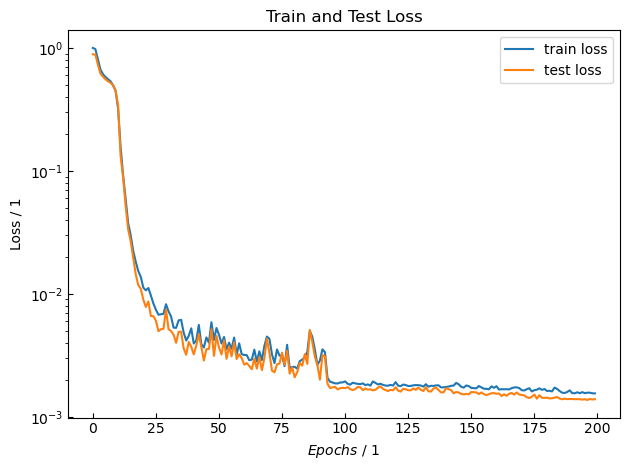

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.998633139705314 , R^2(NH3) = 0.998230867596587
Test Dataset: R^2(H2) = 0.9986769596998942 , R^2(NH3) = 0.9985020793942512
Max Error Training: |x_H2 - x_H2,pred| = 0.05401313280352438 , |x_NH3 - x_NH3,pred| = 0.019608357476890645
Max Error Test: |x_H2 - x_H2,pred| = 0.02649216271686583 , |x_NH3 - x_NH3,pred| = 0.013586241623104317


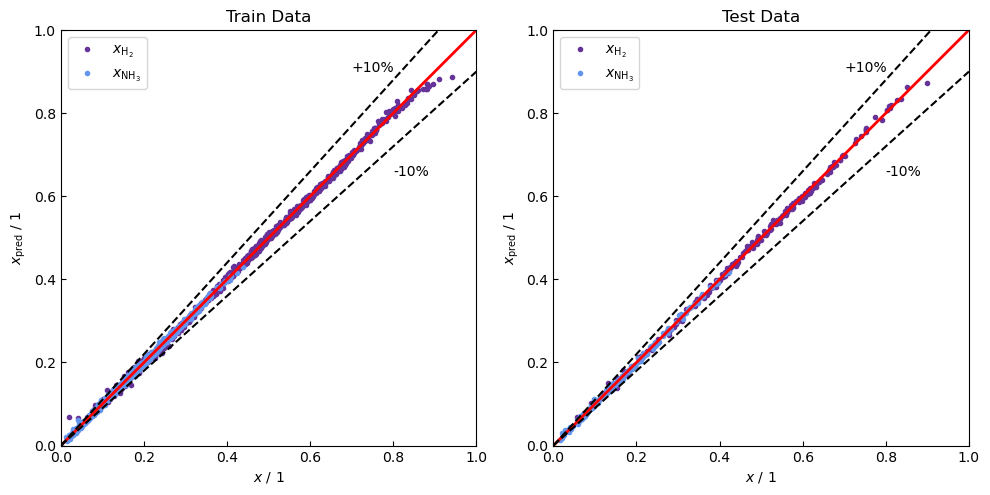

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

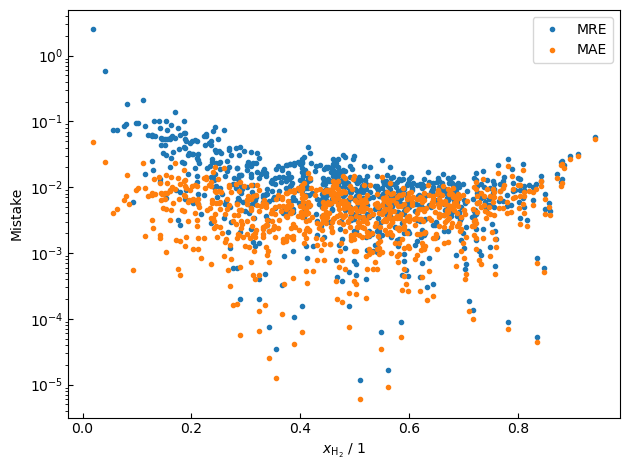

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

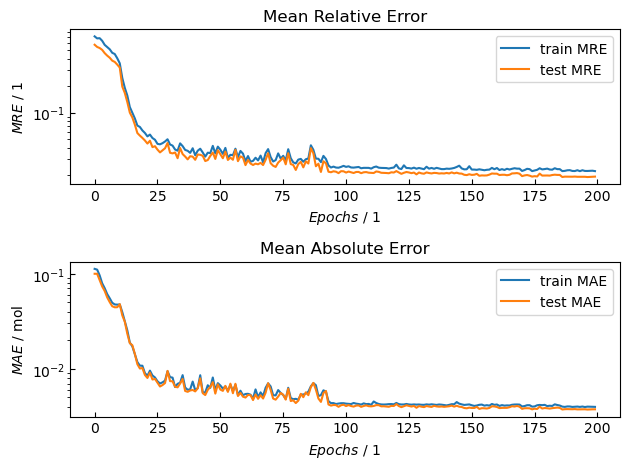

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

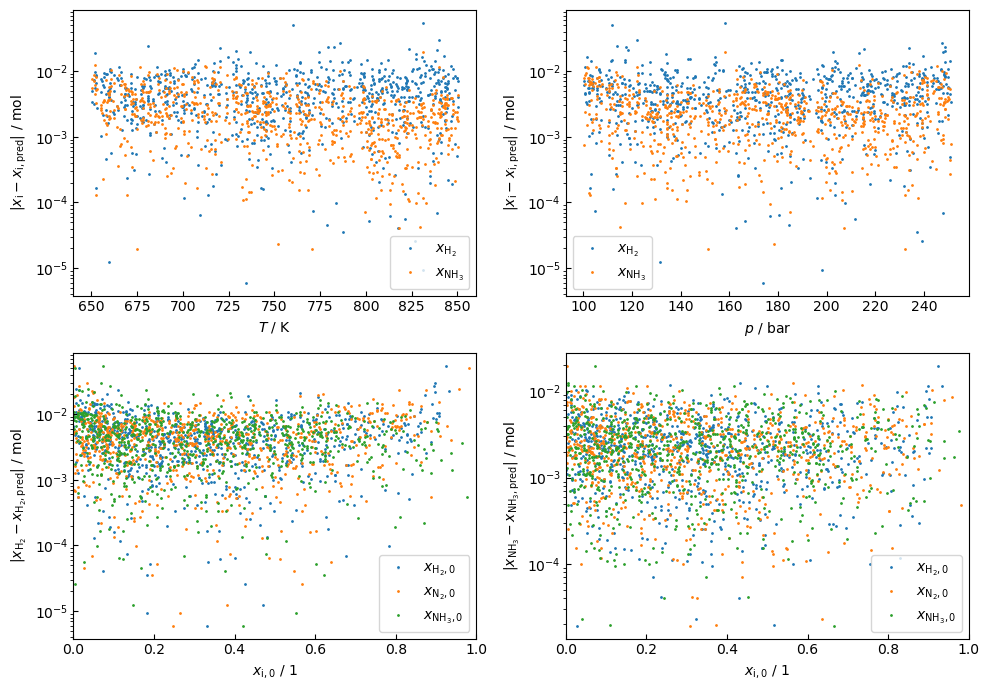

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

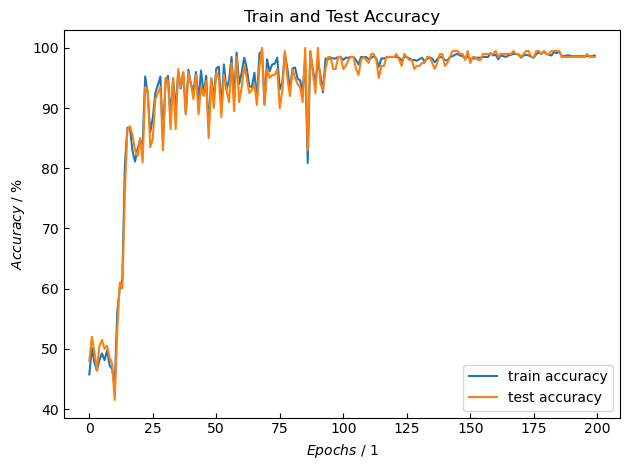

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.0 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 5.7987e-01, -1.4594e+00, -7.8503e-01,  1.8802e+00, -1.1512e+00],
        [-1.6567e+00,  3.3916e-01, -2.7547e-02,  9.2913e-02, -6.7929e-02],
        [-7.5285e-02,  1.1237e+00,  1.7720e+00, -9.2834e-01, -7.9016e-01],
        [-8.1606e-01,  2.1853e-01, -2.0454e-01,  4.5452e-01, -2.6382e-01],
        [ 1.1900e+00,  7.0348e-01, -2.3455e-02, -1.0976e+00,  1.1448e+00],
        [-1.4898e-01,  2.4299e-02, -5.3808e-01, -3.0838e-01,  8.4325e-01],
        [-1.2547e+00, -1.4201e+00,  1.2647e+00, -6.9933e-01, -5.2642e-01],
        [ 8.7402e-01,  1.3128e+00,  3.0843e-01,  2.2257e-01, -5.3017e-01],
        [ 1.7955e-01, -1.2355e+00,  5.0990e-02,  1.0410e+00, -1.1140e+00],
        [-9.5612e-01,  9.8330e-01,  2.4496e+00, -1.1231e+00, -1.2561e+00],
        [ 2.9746e-01,  1.5856e+00,  6.3583e-01, -3.6344e-01, -2.5253e-01],
        [-1.1914e+00,  1.3011e+00,  1.3677e+00, -1.1033e+00, -2.1461e-01],
        [-1.6737e+00, -8.8042e-01, -4.2651e-01,  1.5954e+00, -1.2121e+00],
        [-2.5528e-01,  1.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.2707, -0.0781,  0.0805, -0.1932,  0.0394],
         [ 0.1568, -0.0378, -0.1913,  0.5340, -0.2005],
         [ 0.4552, -0.2799, -0.2421,  0.1681, -0.1339],
         [ 0.0832, -0.0332,  0.7478, -0.2100,  0.2783],
         [-0.5465,  0.1944,  0.5573,  0.0164,  0.4322]], requires_grad=True),
 Parameter containing:
 tensor([ 0.7445,  0.7086,  0.2777, -0.4587, -0.6791], requires_grad=True),
 Parameter containing:
 tensor([[ 6.1523e-01, -3.6475e-01,  2.6634e-01,  4.4789e-01, -3.1173e-04],
         [ 8.8296e-02, -1.0900e+00,  3.1807e-01,  7.8253e-01,  5.7743e-01],
         [-1.3240e+00, -1.6543e-01, -3.9940e-01, -1.0696e-01,  1.8766e-01],
         [ 3.4128e-01,  6.0782e-01,  2.2176e-01, -4.7623e-01, -5.4589e-01],
         [-5.3974e-01,  4.8428e-01, -9.8239e-02, -5.0818e-01, -2.9583e-01]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.3219, -0.5735,  0.2389,  0.4140,  0.3554], requires_grad=True),
 Parameter containing:
 tensor([[-0.7885,  0

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.4349, 0.7059, 0.9787, 0.5018, 0.3241],
        [0.4134, 0.9705, 0.2958, 0.5448, 0.7584]])
tensor([[ 0.2818,  0.2980],
        [-0.0276,  0.2393]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.0918e+00,  1.3515e-01,  6.2630e-01, -8.8850e-01,  2.9348e-01],
        [-1.8482e-01,  3.5686e-01, -3.9482e-04, -4.2353e-01,  4.3327e-01],
        [ 2.2479e-01, -8.9002e-01, -9.1450e-01,  1.9673e+00, -1.1133e+00],
        [-6.1692e-01, -2.0249e-01,  1.1742e+00,  5.3368e-02, -1.2069e+00],
        [-1.4830e+00,  9.4015e-01, -3.4571e-03, -1.1798e+00,  1.2093e+00],
        [ 1.1987e+00, -9.1626e-01, -8.9835e-01, -1.3440e+00,  2.2553e+00],
        [-8.0487e-01, -1.4530e+00, -1.4150e+00, -2.8776e-01,  1.6828e+00],
        [ 1.5173e+00, -7.5462e-01,  2.2044e-01, -6.5872e-01,  4.5692e-01],
        [-1.2146e-02, -9.3620e-01, -4.4086e-01,  1.5594e+00, -1.1612e+00],
        [ 9.3939e-02, -9.9426e-01, -1.2815e+00,  6.2394e-01,  6.1997e-01],
        [-1.3782e+00,  9.6939e-02, -7.1425e-01,  6.9541e-01, -9.8083e-03],
        [ 2.4691e-01, -7.8102e-03,  9.2833e-01,  2.5171e-01, -1.1683e+00],
        [-4.5012e-01,  1.1754e+00, -1.3832e+00,  2.5029e+00, -1.2006e+00],
        [-9.2684e-01, -3.

#### Histogramme Verteilung von $xi$ und $x{_i}$

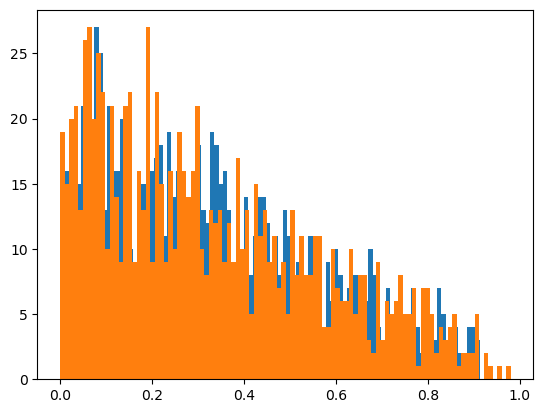

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_040.pth')
# np.savez('data/models/params_005_040.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)